In [2]:
import sys
import glob
import numpy
import string
from matplotlib import pyplot
from nltk.corpus import stopwords
import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt
#import l3
from sklearn.cluster import KMeans 

In [3]:
# Document input
# Structures holding documents and terms
document_list = []	# will contain a list of documents, stored as dictionaries.
				# index in this list is used as ID of document
document_ids = {}	# reverse search: from document name to corresponding ID
token_list = []		# List of token strings; index is token's ID
token_ids = {}		# Reverse dictionary: from token string to ID


In [7]:
# Repeat for every document in processed_pages
for filename in glob.glob('corpusme/*'):
    # Read the document as list of blank-separated tokens
    f = open (filename, 'r', encoding = 'utf-8' ) #encoding = 'utf-8'
    tokens = f.read() 
    #1. tokenization and normalization
        #converting each words to lower case
    tokens = tokens.lower() 
        #separeting each word using space b/n them
    tokens = tokens.split()
        #removing each punctuation and blank space from tokens
    table = str.maketrans(' ', ' ', punctuation)
    tokens = [w.translate(table) for w in tokens] 
    
        #remove remaining tokens that are not alphabetic 
    tokens =[word for word in tokens if word.isalpha()]
    
    
        #removing words that have 1 and/or 2 charectars 
    tokens =[word for word in tokens if len(word)>2 ]
    
    #2.stop word removal
    stop_words = set(stopwords.words('oromo'))
    tokens = [w for w in tokens if not w in stop_words]
    
    f.close()

   
    
    # Get the document name as last part of path
    article_name = filename[filename.rfind('/')+1:]
    #sys.stderr.write (' %s\n' % article_name)
    #print(' %s\n' % article_name)
    # Document's ID is the length of the current document list
    doc_id = len(document_list)
    # Insert ID in inverse list
    document_ids[article_name] = doc_id
    # Populate token structure for all tokens in document
    for t in tokens:
        # Only if token hasn't been seen yet
        if t not in token_ids:
            # Token's ID is token list length
            token_ids[t] = len(token_list)
            # Append token to list
            token_list.append(t)
    # Transform the document's token list into the corresponding ID list
    tids = [token_ids[t] for t in tokens]
    # Store the document as both its token ID list and the corresponding set
    # Also remember the document's name
    document_list.append({
        'name': article_name,
        'tokens': tids,
        'set': set(tids)
    })


In [6]:
    tok = open('token_list.txt', 'w', encoding ='utf-8')
    tok.write(str(token_list))
    tok.close()
    l3.anal_file('om','token_list.txt', 'stemmed.txt' , citation =True, nbest =1)
    fs = open('stemmed.txt', 'r', encoding = 'utf-8')
    stem_list = fs.read()
    noneed1 = 'VBZ'
    noneed2 ='NN'
    noneed3 ='VV'

    stem_list = [c for c in stem_list if c not in noneed1]
    stem_list = [c for c in stem_list if c not in noneed2]
    stem_list = [c for c in stem_list if c not in noneed3]
    stem_list =[word for word in stem_list if not word.isdigit()]
    stem_list = "". join([c for c in stem_list if c not in string.punctuation])
    stem = stem_list.split()

NameError: ignored

In [ ]:
# At the end of the loop, we have the total number of documents and tokens
number_of_documents = len(document_list)
number_of_tokens = len(stem)
sys.stderr.write ('%d documents, %d tokens\n' % (number_of_documents, number_of_tokens))


243 documents, 14683 tokens


In [ ]:

##############################################
# Building the TF-IDF matrix
sys.stderr.write ('Building the TF matrix and counting term occurrencies\n')
# For each term, count how many documents contain it (to compute IDF)
token_count = [0] * number_of_tokens  # number of occurrences of word in document
# Alloc the |T|x|D| TFIDF matrix. No need to initialize its entries
#TF = number of occurrences of word in document/total word in document
TF = numpy.empty((number_of_tokens,number_of_documents), dtype=float) 
# Scan the document list
for i,doc in enumerate(document_list):
	# For each term, count the number of occurrences within the document
	# Initialize with zeros
	n_dt = [0] * number_of_tokens
	# For all token IDs in document
	for tid in doc['tokens']:
		# if first occurrence, increase global count for IDF
		if n_dt[tid] == 0:
			token_count[tid] += 1
		# increase local count
		n_dt[tid] += 1
	# Normalize local count by document length obtaining TF vector;
	# store it as the i-th column of the TFIDF matrix.
	TF[:,i] = numpy.array(n_dt, dtype=float) / len(doc['tokens'])

Building the TF matrix and counting term occurrencies


In [ ]:
# Transform the global count into IDF
sys.stderr.write ('Computing the IDF vector\n')
# IDF = log(number of total document/number of document contains that word)
IDF = numpy.log10(number_of_documents / numpy.array(token_count, dtype=float))
# Apply IDF multipliers to the rows of the TF matrix (left-multiply by diagonal IDF values)
#sys.stderr.write ('Multiplying IDF coefficients into the TF matrix...\n')
# First method: explicitly multiply each row by the appropriate IDF coefficient
#for row,coeff in zip(TF,IDF):
#	row *= coeff
# Second method: beware, numpy.diag(IDF)
# is a VERY large matrix, and should be avoided if the dictionary contains
# more than a few tokens
TFIDF = numpy.diag(IDF).dot(TF)

Computing the IDF vector


In [ ]:

TFIDFM = pd.DataFrame(TFIDF)


In [ ]:
#print(TFIDFM, 5)

#### constructing SVD

In [ ]:
# SVD for rank reduction

#L, S, R = numpy.linalg.svd (TFIDFM, full_matrices =False)


In [ ]:
L_k, S_k, R_k = numpy.linalg.svd (TFIDFM, full_matrices =False)


r1 = 10
L_r1 = L_k[:, :r1]
S_r1 = numpy.diag(S_k)[:r1, :r1]
VT_r1 = R_k[:r1, :]

### reduce SVD for Kmeans

In [ ]:
lowRankX = numpy.dot(L_r1, numpy.dot(S_r1, VT_r1))
lowRankX = pd.DataFrame(lowRankX)
lowRankX =lowRankX.T

### Kmeans (reconstruct reduced SVD) 

In [ ]:
n_clusters = 8
#kmeans = KMeans(n_clusters )
#kmeans = kmeans.fit(lowRankX)
kmeans = KMeans(n_clusters, max_iter=100, n_init=1, verbose=1)
#kmeans = KMeans(n_clusters , init = 'k-means++', max_iter=300, n_init=10,tol = 0.0001, precompute_distances =True, verbose=0, random_state =None, copy_x=True, n_jobs=1)
cluster = kmeans.fit_predict(lowRankX) #
label = kmeans.labels_

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 0.20110439977084418
start iteration
done sorting
end inner loop
Iteration 1, inertia 0.19680018036879682
start iteration
done sorting
end inner loop
Iteration 2, inertia 0.19591144530497048
start iteration
done sorting
end inner loop
Iteration 3, inertia 0.1956502010354422
start iteration
done sorting
end inner loop
Iteration 4, inertia 0.19545481059098313
start iteration
done sorting
end inner loop
Iteration 5, inertia 0.19542102925779714
start iteration
done sorting
end inner loop
Iteration 6, inertia 0.19542102925779714
center shift 0.000000e+00 within tolerance 1.319528e-11


In [ ]:
#label

### selecting number of clusters 

In [ ]:
kmeans.inertia_

0.19542102925779714

In [ ]:
wcss =[]
for i in range(1,12):
    kmeans = KMeans(i)
    kmeans.fit(lowRankX)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

Text(0, 0.5, 'within cluster sum of square')

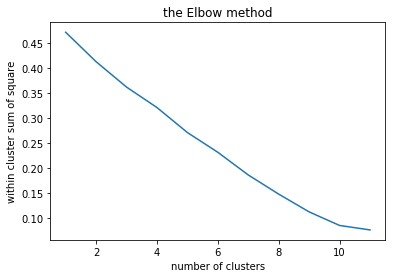

In [ ]:
number_clusters = range(1,12)
plt.plot(number_clusters, wcss)
plt.title('the Elbow method')
plt.xlabel('number of clusters')
plt.ylabel('within cluster sum of square')

In [ ]:
centroid = kmeans.cluster_centers_             #centroid of the clusters
sorted_centroid = centroid.argsort()[:, ::-1]   #sorting centroid
centroid = pd.DataFrame(centroid)             
#centroid

# searching

In [ ]:
query = input('please enter query: ')

please enter query: barnoota


In [ ]:
# Cosine similarity to a query

sys.stderr.write ('Computing query similarities...\n')

#1. tokenization and normalization
        #converting each words to lower case
    
#query = 'abbaa gadaa aanee'
query = query.lower()
# Split the query into its blank-separated tokens
q_split = query.split()
q_split = [w.translate(table) for w in q_split]
        #remove remaining tokens that are not alphabetic 
q_split =[word for word in q_split if word.isalpha()]
q_split =[word for word in q_split if not word.isdigit()]
        #removing words that have 1 and/or 2 charectars 
q_split =[word for word in q_split if len(word)>2 ]

    #2.stop word removal
stop_words = set(stopwords.words('oromo'))
q_split = [w for w in q_split if not w in stop_words]

#stemming


q_tokens = set()

# Compute the occurrences of each token in the query
q_count = [0] * number_of_tokens
q_length = 0
for token in q_split:
	try:
		# Try updating the token's count by finding its ID
		t_id = token_ids[token]
		q_count[t_id] += 1
		q_length += 1
		q_tokens.add(t_id)
	except:
		# If a query token doesn't have an ID, discard it
		pass

Computing query similarities...


In [ ]:
q_split

['barnoota']

In [ ]:
    tok = open('q_split.txt', 'w', encoding ='utf-8')
    tok.write(str(q_split))
    tok.close()
    l3.anal_file('om','q_split.txt', 'stemm_q.txt' , citation =True, nbest =1)
    fq = open('stemm_q.txt', 'r', encoding = 'utf-8')
    qr_list = fq.read()
    noneed1 = 'VBZ'
    noneed2 ='NN'
    noneed3 ='VV'

    qr_list = [c for c in qr_list if c not in noneed1]
    qr_list = [c for c in qr_list if c not in noneed2]
    qr_list = [c for c in qr_list if c not in noneed3]
    qr_list =[word for word in qr_list if not word.isdigit()]
    qr_list = "". join([c for c in qr_list if c not in string.punctuation])
    qr_list = qr_list.split()
    

In [ ]:
qr_list

['barnoota']

### normalize query and tfidf, measure similarity 

In [ ]:
# Normalize by query length and multiply (elementwise) by IDF
# to get TF-IDF representation of query
q_TFIDF = (numpy.array(q_count,dtype=float) / q_length) * IDF

# In order to compute cosine similarity, we need to normalize each
# document (TFIDF column) by its length (2-norm)
#TFIDF_norm = TFIDFM.dot(numpy.diag([1/numpy.linalg.norm(col) for col in TFIDF.T]))

# Same normalization applies to the query vector
#q_TFIDF_norm = q_TFIDF / numpy.linalg.norm(q_TFIDF)
# Array of cosine similarities (dot products of normalized document and query vectors)
# is obtained by matrix-vector multiplication.
#sim = TFIDF_norm.T.dot(q_TFIDF_norm)
sim = TFIDFM.T.dot(q_TFIDF)

### find query result using VSM

In [ ]:
# Function to print the names of the "N" documents with the highest
# ranking in the list "sim"; if "sim" contains distances (i.e., the smaller the better),
# then set "smallest" to True.
N= len(document_list)
def print_top(sim,N,smallest=False):
    sorted_sim = sorted(enumerate(sim),key=lambda t:t[1], reverse= not smallest)
    for i,s in sorted_sim[:N]:
        if s>0:
            #print(s, document_list[i]['name'])
           
            #print(i, s,  document_list[i]['name'])
            print(  document_list[i]['name'])

#### lists of ranked document using VSM

In [ ]:
print_top(sim,N, False )

corpusme\doc66 education.txt
corpusme\doc32 education.txt
corpusme\doc61 education.txt
corpusme\doc230 education.txt
corpusme\doc170 education.txt
corpusme\doc189 education.txt
corpusme\doc212 education.txt
corpusme\doc112 education.txt
corpusme\doc107 education.txt
corpusme\doc223 education.txt
corpusme\doc201 education.txt
corpusme\doc181 education.txt
corpusme\doc68 education.txt
corpusme\doc94 education.txt
corpusme\doc62 education.txt
corpusme\doc65 education.txt
corpusme\doc126 education.txt
corpusme\doc134 education.txt
corpusme\doc135 social.txt
corpusme\doc56 education.txt
corpusme\doc39 education.txt
corpusme\doc239 education.txt
corpusme\doc197 business agri.txt
corpusme\doc123 politics.txt
corpusme\doc64 education.txt
corpusme\doc63 education.txt
corpusme\doc74 politics.txt
corpusme\doc111 politics.txt
corpusme\doc57 social.txt
corpusme\doc150 education.txt
corpusme\doc153 religous.txt
corpusme\doc55 politics.txt
corpusme\doc67 eduction.txt
corpusme\doc143 education.txt
cor

### find query result using SVD 

In [ ]:
# Compute the cosine similarity array given the SVD decomposition of
# the TFIDF matrix (computed above), the normalized TFIDF query vector q
# and the desired rank r1

def reduced_similarity (r1, L_k, S_k, R_k, q):
    L_r1 = L_k[:, :r1]
    S_r1 = numpy.diag(S_k)[:r1, :r1]
    VT_r1 = R_k[:r1, :]
    
    q_r1 = S_r1.dot(L_r1.T).dot(q_TFIDF)
    return VT_r1.T.dot(q_r1)


In [ ]:
# Test the above function
sim_r1 = reduced_similarity (r1,L_k, S_k, R_k, q_TFIDF)

#### lists of ranked document using SVD

In [ ]:
#print ("Top cosine similarities after SVD:")
print_top (sim_r1,N)


corpusme\doc32 education.txt
corpusme\doc66 education.txt
corpusme\doc61 education.txt
corpusme\doc189 education.txt
corpusme\doc170 education.txt
corpusme\doc181 education.txt
corpusme\doc39 education.txt
corpusme\doc150 education.txt
corpusme\doc134 education.txt
corpusme\doc223 education.txt
corpusme\doc230 education.txt
corpusme\doc212 education.txt
corpusme\doc135 social.txt
corpusme\doc68 education.txt
corpusme\doc126 education.txt
corpusme\doc143 education.txt
corpusme\doc201 education.txt
corpusme\doc112 education.txt
corpusme\doc62 education.txt
corpusme\doc107 education.txt
corpusme\doc64 education.txt
corpusme\doc94 education.txt
corpusme\doc159 health.txt
corpusme\doc56 education.txt
corpusme\doc239 education.txt
corpusme\doc65 education.txt
corpusme\doc63 education.txt
corpusme\doc67 eduction.txt
corpusme\doc101 health.txt
corpusme\doc74 politics.txt
corpusme\doc57 social.txt
corpusme\doc123 politics.txt
corpusme\doc139 social.txt
corpusme\doc153 religous.txt
corpusme\doc1

### find query result using SVD + Kmeans

In [ ]:

c_qsim =centroid.dot(q_TFIDF)                 #calculating similarity b/n cluster centroid and query vector
#c_qsim = pd.DataFrame(c_qsim)
#c_qsim
my_dict =c_qsim.to_dict()  
#my_dict                                # max similarity b/n centroid and query vector

def get_key(val): 
    for key, value in my_dict.items(): 
         if val == value: 
             return key 
        
w = get_key(c_qsim.max())             #view cluster with max centroid similarity with query
                                      #c_qsim.max() is used to select max value of similarity b/n centroid and query
                                      # w is cluster with max similarity b/n query and centroid
              
doc_dict = {i: numpy.where(label ==i)[0] for i in range(kmeans.n_clusters)}
doc_dict_key = list(doc_dict.keys())
doc_dict_val = list(doc_dict.values()) 

In [ ]:
doc_list = []
for key in doc_dict.keys():
    if  w == key:
        temp = doc_dict[w]
        doc_list.append(temp)
        #print (list(doc_dict[w]))
        print(doc_list)


[array([  8,  15,  30,  39,  40,  49,  57,  66,  79,  90,  98, 113, 125,
       137, 145, 154, 169, 176, 195, 201, 202, 204, 205, 206, 208, 237],
      dtype=int64)]


In [ ]:
doc_list = []
for key in doc_dict.keys():
    if  w == key:
        print ( 'doc:', list(doc_dict[w]))
      

doc: [8, 15, 30, 39, 40, 49, 57, 66, 79, 90, 98, 113, 125, 137, 145, 154, 169, 176, 195, 201, 202, 204, 205, 206, 208, 237]
